# Neural Network with Keras

In [31]:
import pandas as pd
import os 
import json
import matplotlib.pyplot as plt

In [2]:
# Set the seed value for the notebook so the results are reproducible
# from numpy.random import seed
# seed(42)

In [3]:
# Generate Data
national_data = pd.read_json("../../Scraping/Output/national_data_final.json")
national_data = national_data[national_data['currency']=="MXN"]
national_data.columns

Index(['index', 'url', 'type_of_offer', 'type_of_prop', 'name', 'price',
       'currency', 'Estado', 'Ciudad', 'Colonia', 'Superficie total',
       'Superficie construida', 'Recamaras', 'Banos', 'Estacionamientos',
       'Antiguedad', 'Cuota mensual de mantenimiento', 'Ambientes', 'Bodegas',
       'Cantidad de pisos', 'site', 'Orientación', 'Departamentos por piso',
       'Tipo de departamento', 'Número de piso de la unidad', 'Disposición',
       'Tipo de casa', 'Tipo de propiedad', 'cp'],
      dtype='object')

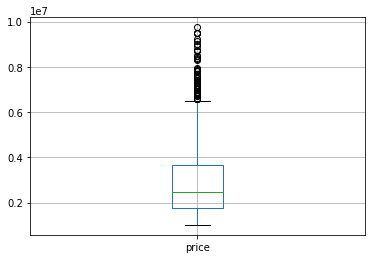

In [4]:
national_data = national_data[national_data['currency']=='MXN']
national_data = national_data[national_data['name'].str.contains('Renta')==False]
national_data = national_data[national_data['cp'].isnull()==False]

national_data = national_data[national_data['price']>1000000]
national_data = national_data[national_data['price']<10000000]
national_data = national_data[national_data['Superficie total']<300]

national_data['price'].plot.box(grid='True')

In [5]:
# Replace NA's with 0

national_data_clean = national_data.fillna(0)
national_data_clean

,index,url,type_of_offer,type_of_prop,name,price,currency,Estado,Ciudad,Colonia,...,Cantidad de pisos,site,Orientación,Departamentos por piso,Tipo de departamento,Número de piso de la unidad,Disposición,Tipo de casa,Tipo de propiedad,cp
1,1,https://departamento.metroscubicos.com/MLM-960...,sale,apartments,Departamento En Venta En Aguascalientes,2100000,MXN,Aguascalientes,Aguascalientes,Los Pocitos,...,0.0,Data\Aguascalientes_ap.json,0,0.0,0,0.0,0,0,0,20328.0
3,3,https://departamento.metroscubicos.com/MLM-792...,sale,apartments,"Hurban Vende Departamentos En Primero, Segundo...",1700000,MXN,Aguascalientes,Aguascalientes,Circunvalación Poniente,...,0.0,Data\Aguascalientes_ap.json,0,0.0,0,0.0,0,0,0,20210.0
4,4,https://departamento.metroscubicos.com/MLM-792...,sale,apartments,Terzetto Departamento En Venta En Aguascalientes,5000000,MXN,Aguascalientes,Aguascalientes,Terzetto,...,0.0,Data\Aguascalientes_ap.json,0,0.0,0,0.0,0,0,0,20118.0
5,5,https://departamento.metroscubicos.com/MLM-792...,sale,apartments,Punta Del Cielo (departamento 3 Recamaras) En ...,3864638,MXN,Aguascalientes,Aguascalientes,Residencial Campestre Club De Golf Sur,...,0.0,Data\Aguascalientes_ap.json,0,0.0,0,0.0,0,0,0,20130.0
6,6,https://departamento.metroscubicos.com/MLM-792...,sale,apartments,Hurban Vende Departamento Nuevo En Coto Al Nor...,1098500,MXN,Aguascalientes,Aguascalientes,Residencial Las Plazas,...,0.0,Data\Aguascalientes_ap.json,0,0.0,0,0.0,0,0,0,20126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6748,37,https://casa.metroscubicos.com/MLM-939021304-s...,sale,houses,Se Vende Casa De Inversión En Obra Blanca,2350000,MXN,Zacatecas,Zacatecas,Cnop,...,0.0,Data\Zacatecas_hs.json,0,0.0,0,0.0,0,0,0,98053.0
6749,38,https://casa.metroscubicos.com/MLM-939026559-c...,sale,houses,Casa Sola En Venta Industrial,2000000,MXN,Zacatecas,Fresnillo,Industrial,...,0.0,Data\Zacatecas_hs.json,0,0.0,0,0.0,0,0,0,99030.0
6750,39,https://casa.metroscubicos.com/MLM-939030255-c...,sale,houses,Casa En Venta Colonia Lasalle,2950000,MXN,Zacatecas,Fresnillo,Lasalle,...,0.0,Data\Zacatecas_hs.json,0,0.0,0,0.0,0,0,0,99040.0
6755,44,https://casa.metroscubicos.com/MLM-921529202-c...,sale,houses,Casa En Venta En Villanueva Centro,1606052,MXN,Zacatecas,Villanueva,Villanueva Centro,...,2.0,Data\Zacatecas_hs.json,0,0.0,0,0.0,0,Casa,Casa en condominio,99540.0


In [6]:
national_data_clean["type_of_prop"].unique()

array(['apartments', 'houses'], dtype=object)

In [7]:
national_data_clean.columns

Index(['index', 'url', 'type_of_offer', 'type_of_prop', 'name', 'price',
       'currency', 'Estado', 'Ciudad', 'Colonia', 'Superficie total',
       'Superficie construida', 'Recamaras', 'Banos', 'Estacionamientos',
       'Antiguedad', 'Cuota mensual de mantenimiento', 'Ambientes', 'Bodegas',
       'Cantidad de pisos', 'site', 'Orientación', 'Departamentos por piso',
       'Tipo de departamento', 'Número de piso de la unidad', 'Disposición',
       'Tipo de casa', 'Tipo de propiedad', 'cp'],
      dtype='object')

In [8]:
# Changing to Boolean
# Changing Houses to 1 and Apartments to 0
national_data_clean.dtypes


index                               int64
url                                object
type_of_offer                      object
type_of_prop                       object
name                               object
price                               int64
currency                           object
Estado                             object
Ciudad                             object
Colonia                            object
Superficie total                  float64
Superficie construida             float64
Recamaras                         float64
Banos                             float64
Estacionamientos                  float64
Antiguedad                        float64
Cuota mensual de mantenimiento    float64
Ambientes                         float64
Bodegas                           float64
Cantidad de pisos                 float64
site                               object
Orientación                        object
Departamentos por piso            float64
Tipo de departamento              

# Scatters

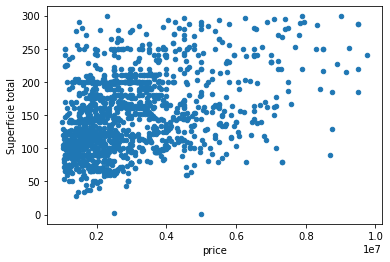

In [36]:
# Correlation Between Factors
# Price vs Superficie Total
national_data_clean.plot.scatter(x="price",y="Superficie total")

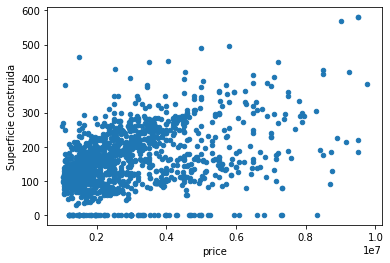

In [37]:
# Price vs Superficie Construida
national_data_clean.plot.scatter(x="price",y="Superficie construida")

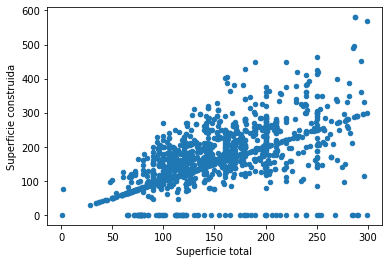

In [38]:
# Superficie Total vs Superficie Construida
national_data_clean.plot.scatter(x="Superficie total",y="Superficie construida")

# Read and Features

In [9]:
# Read Data

X_full = national_data_clean
# X_test_full = pd.read_csv("")

# Obtain Target and Predictions
y = X_full.price

features = ['type_of_prop', 'Superficie total',
       'Superficie construida', 'Ambientes', 'Recamaras', 'Banos',
       'Estacionamientos', 'Antiguedad', 'Cantidad de pisos',
       'Cuota mensual de mantenimiento', 'Bodegas']

X = X_full[features]

In [10]:
X.type_of_prop = X.type_of_prop.map({"houses":1,"apartments":0})

/Users/orlandogarciaylopez/opt/anaconda3/envs/PythonData2/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
# X_full Replace Houses for 1 and Apartments for 0
X["type_of_prop"].unique()
# national_data_clean["type_of_prop"] = national_data_clean["type_of_prop"].astype(float)

array([0, 1])

In [12]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
X_train.head()

,type_of_prop,Superficie total,Superficie construida,Ambientes,Recamaras,Banos,Estacionamientos,Antiguedad,Cantidad de pisos,Cuota mensual de mantenimiento,Bodegas
2506,0,65.0,65.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
6320,0,98.0,78.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2420,0,150.0,150.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0
5124,0,96.0,160.0,0.0,2.0,2.0,2.0,0.0,6.0,0.0,0.0
4185,1,112.0,165.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0


# Cleaning

In [14]:
# Categorical Variables

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
[]


# Data Preprocessing

In [15]:

from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Model Architecture

In [16]:
# Defining Our Model Architecture

from tensorflow.keras.models import Sequential

model = Sequential()

In [17]:
len(X_train.columns)

11

In [18]:
from tensorflow.keras.layers import Dense
number_inputs = 11
number_hidden_nodes = 4
model.add(Dense(number_inputs,
                input_dim=number_inputs,
                activation='relu',
                kernel_initializer='normal'))

In [19]:
# number
model.add(Dense(1, kernel_initializer='normal'))

# Summary

In [20]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the Model

import tensorflow

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

In [22]:
type(X_train_scaled)

numpy.ndarray

In [23]:
type(y_train)

pandas.core.series.Series

In [24]:
y_train.values

array([1804517, 2979684, 5850000, ..., 2500000, 2400000, 1300000])

# Fit

In [25]:
# Fit (train) the model
model.fit(
    X_train_scaled,
    y_train.values,
    epochs=500,
    shuffle=True,
    verbose=2
)

Train on 1059 samples
Epoch 1/500
1059/1059 - 2s - loss: 11367805829259.2402 - root_mean_squared_error: 3371617.5000
Epoch 2/500
1059/1059 - 0s - loss: 11367805406957.3867 - root_mean_squared_error: 3371618.0000
Epoch 3/500
1059/1059 - 0s - loss: 11367804026183.7969 - root_mean_squared_error: 3371618.0000
Epoch 4/500
1059/1059 - 0s - loss: 11367802818687.6367 - root_mean_squared_error: 3371617.2500
Epoch 5/500
1059/1059 - 0s - loss: 11367800806194.0391 - root_mean_squared_error: 3371617.0000
Epoch 6/500
1059/1059 - 0s - loss: 11367798391201.7227 - root_mean_squared_error: 3371616.5000
Epoch 7/500
1059/1059 - 0s - loss: 11367794401860.1699 - root_mean_squared_error: 3371616.0000
Epoch 8/500
1059/1059 - 0s - loss: 11367789920410.7109 - root_mean_squared_error: 3371615.2500
Epoch 9/500
1059/1059 - 0s - loss: 11367784145321.4570 - root_mean_squared_error: 3371614.5000
Epoch 10/500
1059/1059 - 0s - loss: 11367777445178.2578 - root_mean_squared_error: 3371613.5000
Epoch 11/500
1059/1059 - 0s

Epoch 87/500
1059/1059 - 0s - loss: 11365389005894.5879 - root_mean_squared_error: 3371259.2500
Epoch 88/500
1059/1059 - 0s - loss: 11365340482520.3555 - root_mean_squared_error: 3371252.2500
Epoch 89/500
1059/1059 - 0s - loss: 11365290563767.7207 - root_mean_squared_error: 3371244.7500
Epoch 90/500
1059/1059 - 0s - loss: 11365238675593.3066 - root_mean_squared_error: 3371237.0000
Epoch 91/500
1059/1059 - 0s - loss: 11365186250753.9336 - root_mean_squared_error: 3371229.2500
Epoch 92/500
1059/1059 - 0s - loss: 11365135930987.8164 - root_mean_squared_error: 3371221.7500
Epoch 93/500
1059/1059 - 0s - loss: 11365083539813.7715 - root_mean_squared_error: 3371213.7500
Epoch 94/500
1059/1059 - 0s - loss: 11365031625895.2832 - root_mean_squared_error: 3371206.0000
Epoch 95/500
1059/1059 - 0s - loss: 11364978403979.7246 - root_mean_squared_error: 3371198.2500
Epoch 96/500
1059/1059 - 0s - loss: 11364926030876.0410 - root_mean_squared_error: 3371190.7500
Epoch 97/500
1059/1059 - 0s - loss: 1136

Epoch 172/500
1059/1059 - 0s - loss: 11359767047600.2266 - root_mean_squared_error: 3370425.5000
Epoch 173/500
1059/1059 - 0s - loss: 11359685324517.6504 - root_mean_squared_error: 3370413.0000
Epoch 174/500
1059/1059 - 0s - loss: 11359601248822.6328 - root_mean_squared_error: 3370400.5000
Epoch 175/500
1059/1059 - 0s - loss: 11359518594002.5527 - root_mean_squared_error: 3370388.5000
Epoch 176/500
1059/1059 - 0s - loss: 11359433726924.7520 - root_mean_squared_error: 3370376.2500
Epoch 177/500
1059/1059 - 0s - loss: 11359351000070.7676 - root_mean_squared_error: 3370364.0000
Epoch 178/500
1059/1059 - 0s - loss: 11359266906552.9277 - root_mean_squared_error: 3370351.2500
Epoch 179/500
1059/1059 - 0s - loss: 11359183011561.5176 - root_mean_squared_error: 3370338.5000
Epoch 180/500
1059/1059 - 0s - loss: 11359098071954.7344 - root_mean_squared_error: 3370326.2500
Epoch 181/500
1059/1059 - 0s - loss: 11359013358103.6914 - root_mean_squared_error: 3370313.2500
Epoch 182/500
1059/1059 - 0s -

Epoch 257/500
1059/1059 - 0s - loss: 11351467017042.9160 - root_mean_squared_error: 3369193.5000
Epoch 258/500
1059/1059 - 0s - loss: 11351355955120.7109 - root_mean_squared_error: 3369177.7500
Epoch 259/500
1059/1059 - 0s - loss: 11351241080104.8535 - root_mean_squared_error: 3369160.5000
Epoch 260/500
1059/1059 - 0s - loss: 11351129229027.7168 - root_mean_squared_error: 3369143.7500
Epoch 261/500
1059/1059 - 0s - loss: 11351013660902.1328 - root_mean_squared_error: 3369126.5000
Epoch 262/500
1059/1059 - 0s - loss: 11350899069071.1094 - root_mean_squared_error: 3369109.5000
Epoch 263/500
1059/1059 - 0s - loss: 11350777889479.6758 - root_mean_squared_error: 3369091.5000
Epoch 264/500
1059/1059 - 0s - loss: 11350664259338.3945 - root_mean_squared_error: 3369074.5000
Epoch 265/500
1059/1059 - 0s - loss: 11350550042776.7773 - root_mean_squared_error: 3369057.7500
Epoch 266/500
1059/1059 - 0s - loss: 11350436044049.6465 - root_mean_squared_error: 3369041.0000
Epoch 267/500
1059/1059 - 0s -

Epoch 342/500
1059/1059 - 0s - loss: 11340776908492.5098 - root_mean_squared_error: 3367607.0000
Epoch 343/500
1059/1059 - 0s - loss: 11340637415456.8750 - root_mean_squared_error: 3367586.2500
Epoch 344/500
1059/1059 - 0s - loss: 11340495569808.8008 - root_mean_squared_error: 3367565.0000
Epoch 345/500
1059/1059 - 0s - loss: 11340355727000.2930 - root_mean_squared_error: 3367544.7500
Epoch 346/500
1059/1059 - 0s - loss: 11340215657940.9707 - root_mean_squared_error: 3367523.5000
Epoch 347/500
1059/1059 - 0s - loss: 11340072244627.2188 - root_mean_squared_error: 3367502.5000
Epoch 348/500
1059/1059 - 0s - loss: 11339931792872.3086 - root_mean_squared_error: 3367481.2500
Epoch 349/500
1059/1059 - 0s - loss: 11339787965673.0352 - root_mean_squared_error: 3367460.0000
Epoch 350/500
1059/1059 - 0s - loss: 11339644137483.6035 - root_mean_squared_error: 3367439.0000
Epoch 351/500
1059/1059 - 0s - loss: 11339497111087.8652 - root_mean_squared_error: 3367416.7500
Epoch 352/500
1059/1059 - 0s -

Epoch 427/500
1059/1059 - 0s - loss: 11327607669231.0781 - root_mean_squared_error: 3365651.2500
Epoch 428/500
1059/1059 - 0s - loss: 11327433668985.1113 - root_mean_squared_error: 3365625.2500
Epoch 429/500
1059/1059 - 0s - loss: 11327261732225.8145 - root_mean_squared_error: 3365599.7500
Epoch 430/500
1059/1059 - 0s - loss: 11327093161999.4707 - root_mean_squared_error: 3365574.5000
Epoch 431/500
1059/1059 - 0s - loss: 11326924501173.7871 - root_mean_squared_error: 3365549.7500
Epoch 432/500
1059/1059 - 0s - loss: 11326752864927.0645 - root_mean_squared_error: 3365524.0000
Epoch 433/500
1059/1059 - 0s - loss: 11326580748949.3945 - root_mean_squared_error: 3365498.7500
Epoch 434/500
1059/1059 - 0s - loss: 11326408834468.6230 - root_mean_squared_error: 3365472.7500
Epoch 435/500
1059/1059 - 0s - loss: 11326236171429.3477 - root_mean_squared_error: 3365447.5000
Epoch 436/500
1059/1059 - 0s - loss: 11326058277887.0332 - root_mean_squared_error: 3365421.2500
Epoch 437/500
1059/1059 - 0s -

# Quantifying the Model

In [26]:
# Quantifying the Model

# Evaluate the model using the testing data
model_loss, rmse = model.evaluate(
    X_test_scaled, y_test.values, verbose=2)
print(f"Loss: {model_loss}, Root Mean Squared Error: {rmse}")

353/1 - 0s - loss: 7676759501374.3682 - root_mean_squared_error: 3186132.2500
Loss: 10151438570620.736, Root Mean Squared Error: 3186132.25


In [27]:
X_test.iloc[1,:].values.T

array([  0., 160., 160.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,   0.])

# Metrics

In [28]:
from sklearn.metrics import mean_absolute_error

prediction = model.predict(X_test)
mean_absolute_error(prediction,y_test)


1911110.5295697015

In [29]:
# Making predictions with the new data

import numpy as np
new_data = X_test_scaled[1:10]
print(f"Predicted Regression: {model.predict(new_data)}")

Predicted Regression: [[ 2441.5652]
 [ 4119.622 ]
 [13701.985 ]
 [ 3378.8547]
 [ 8351.091 ]
 [ 1197.1757]
 [ 6980.8096]
 [14688.577 ]
 [15951.261 ]]
